In [2]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))

setwd("/frazer01/home/jennifer/jn_projects/ppc_pilot/pipeline")

# Integrate

In [3]:
data_dir = "/projects/PPC/pipeline/scRNA-Seq/sample"
samples = c("scRNA_10x_MIX_PPC_001", "scRNA_10X_MIX_PPC_002", "aggr_individual")

In [22]:
objList = list()
for (s in samples){
    message(s)
    if (s == "aggr_individual"){
        path = paste(data_dir, s, "outs", "count", "filtered_feature_bc_matrix", sep = "/")
    } else {
        path = paste(data_dir, s, "outs", "filtered_feature_bc_matrix", sep = "/")
    }
    message(path)
    data <- Read10X(data.dir = path)
    obj <- CreateSeuratObject(counts = data, project = s)
    obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^MT-")
    objList[s] = obj
}

scRNA_10x_MIX_PPC_001

/projects/PPC/pipeline/scRNA-Seq/sample/scRNA_10x_MIX_PPC_001/outs/filtered_feature_bc_matrix

scRNA_10X_MIX_PPC_002

/projects/PPC/pipeline/scRNA-Seq/sample/scRNA_10X_MIX_PPC_002/outs/filtered_feature_bc_matrix

aggr_individual

/projects/PPC/pipeline/scRNA-Seq/sample/aggr_individual/outs/count/filtered_feature_bc_matrix



In [23]:
for (i in 1:length(objList)) {
    objList[[i]] <- NormalizeData(objList[[i]], verbose = FALSE)
    objList[[i]] <- FindVariableFeatures(objList[[i]], selection.method = "vst", nfeatures = 2000, verbose = FALSE, dispersion.cutoff = c(0.5,Inf))
}

In [24]:
save(objList, file = paste("2.scRNA_seq", "objList.robj", sep = "/"))

In [10]:
load(paste("2.scRNA_seq", "objList.robj", sep = "/"), verbose = T)

Loading objects:
  objList


In [ ]:
anchors <- FindIntegrationAnchors(object.list = objList, dims = 1:30)

In [ ]:
save(anchors, file = paste("2.scRNA_seq", "anchors.robj", sep = "/"))

In [ ]:
integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

In [ ]:
save(integrated, file = paste("2.scRNA_seq", "integrated.robj", sep = "/"))

In [76]:
DefaultAssay(integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(integrated, npcs = 30, verbose = FALSE)
integrated <- RunUMAP(integrated, reduction = "pca", dims = 1:30, verbose = F)

In [ ]:
save(integrated, file = paste("2.scRNA_seq", "integrated.robj", sep = "/"))

In [68]:
load(paste("2.scRNA_seq", "integrated.robj", sep = "/"), verbose = T)

Loading objects:
  integrated


In [69]:
nrow(integrated@meta.data)

[1] 99819

# Filter

In [99]:
DefaultAssay(integrated) = "RNA"
integrated[["percent.mt"]] <- PercentageFeatureSet(integrated, pattern = "^MT-")

In [71]:
meta = rbind(objList[[1]]@meta.data, objList[[2]]@meta.data)
meta = rbind(meta, objList[[3]]@meta.data)
meta$barcode = rownames(meta)

[1] 99819

In [89]:
int.meta = integrated@meta.data
int.meta$barcode = unlist(lapply(rownames(int.meta), function(x) { unlist(strsplit(x, "_"))[1] }))
int.meta$seurat_id = rownames(int.meta)
int.meta = merge(int.meta, meta, by = c("orig.ident", "nCount_RNA", "nFeature_RNA", "barcode"))
rownames(int.meta) = int.meta$seurat_id
head(int.meta)

nrow(int.meta)

,orig.ident,nCount_RNA,nFeature_RNA,barcode,seurat_id,percent.mt
,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>
CTTGAGAGTACTAACC-2_3,aggr_individual,1000,257,CTTGAGAGTACTAACC-2,CTTGAGAGTACTAACC-2_3,72.2
GTGGTTACACTCCTTG-4_3,aggr_individual,1000,385,GTGGTTACACTCCTTG-4,GTGGTTACACTCCTTG-4_3,54.8
GAGCTGCGTGTATCCA-2_3,aggr_individual,1000,433,GAGCTGCGTGTATCCA-2,GAGCTGCGTGTATCCA-2_3,50.4
CTGGACGGTCCACATA-6_3,aggr_individual,1000,490,CTGGACGGTCCACATA-6,CTGGACGGTCCACATA-6_3,46.4
GCACGTGTCGACACCG-3_3,aggr_individual,1000,499,GCACGTGTCGACACCG-3,GCACGTGTCGACACCG-3_3,39.1
TTCCGGTGTAGAGCTG-2_3,aggr_individual,1000,703,TTCCGGTGTAGAGCTG-2,TTCCGGTGTAGAGCTG-2_3,7.9


[1] 99753

In [82]:
meta[rownames(meta) %like% "AAACCCAAGAGGGTCT",]
integrated@meta.data[rownames(integrated@meta.data) %like% "AAACCCAAGAGGGTCT",]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,barcode
,<fct>,<dbl>,<int>,<dbl>,<chr>
AAACCCAAGAGGGTCT-1,scRNA_10x_MIX_PPC_001,4718,2103,11.5727,AAACCCAAGAGGGTCT-1


,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
AAACCCAAGAGGGTCT-1_1,scRNA_10x_MIX_PPC_001,4718,2103


In [64]:
suppressMessages(library(cowplot))
suppressMessages(source("~/scripts/functions.R"))

In [66]:
meta = int.meta
meta = add_rownames(merge(meta, Embeddings(integrated, "umap"), by = "row.names", all.x = T))

,orig.ident,nCount_RNA,nFeature_RNA,barcode,seurat_id,percent.mt,UMAP_1,UMAP_2
,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
AAACCCAAGAACCGCA-6_3,aggr_individual,959,680,AAACCCAAGAACCGCA-6,AAACCCAAGAACCGCA-6_3,15.119917,1.6630389,7.0315962
AAACCCAAGAAGTCAT-2_3,aggr_individual,21162,5803,AAACCCAAGAAGTCAT-2,AAACCCAAGAAGTCAT-2_3,6.521123,0.2182443,-3.6337244
AAACCCAAGACAGCTG-2_3,aggr_individual,30095,6762,AAACCCAAGACAGCTG-2,AAACCCAAGACAGCTG-2_3,6.732015,1.2696760,-6.2317190
AAACCCAAGACCATGG-1_3,aggr_individual,12245,3585,AAACCCAAGACCATGG-1,AAACCCAAGACCATGG-1_3,14.691711,12.2681176,-1.9510411
AAACCCAAGAGGGTCT-1_1,scRNA_10x_MIX_PPC_001,4718,2103,AAACCCAAGAGGGTCT-1,AAACCCAAGAGGGTCT-1_1,11.572700,-4.6505807,-0.5628369
AAACCCAAGATGCGAC-5_3,aggr_individual,5192,2376,AAACCCAAGATGCGAC-5,AAACCCAAGATGCGAC-5_3,10.458398,-5.4808143,-3.5976989



  FALSE    TRUE 
0.10526 0.89474 


     FALSE       TRUE 
0.08507012 0.91492988 

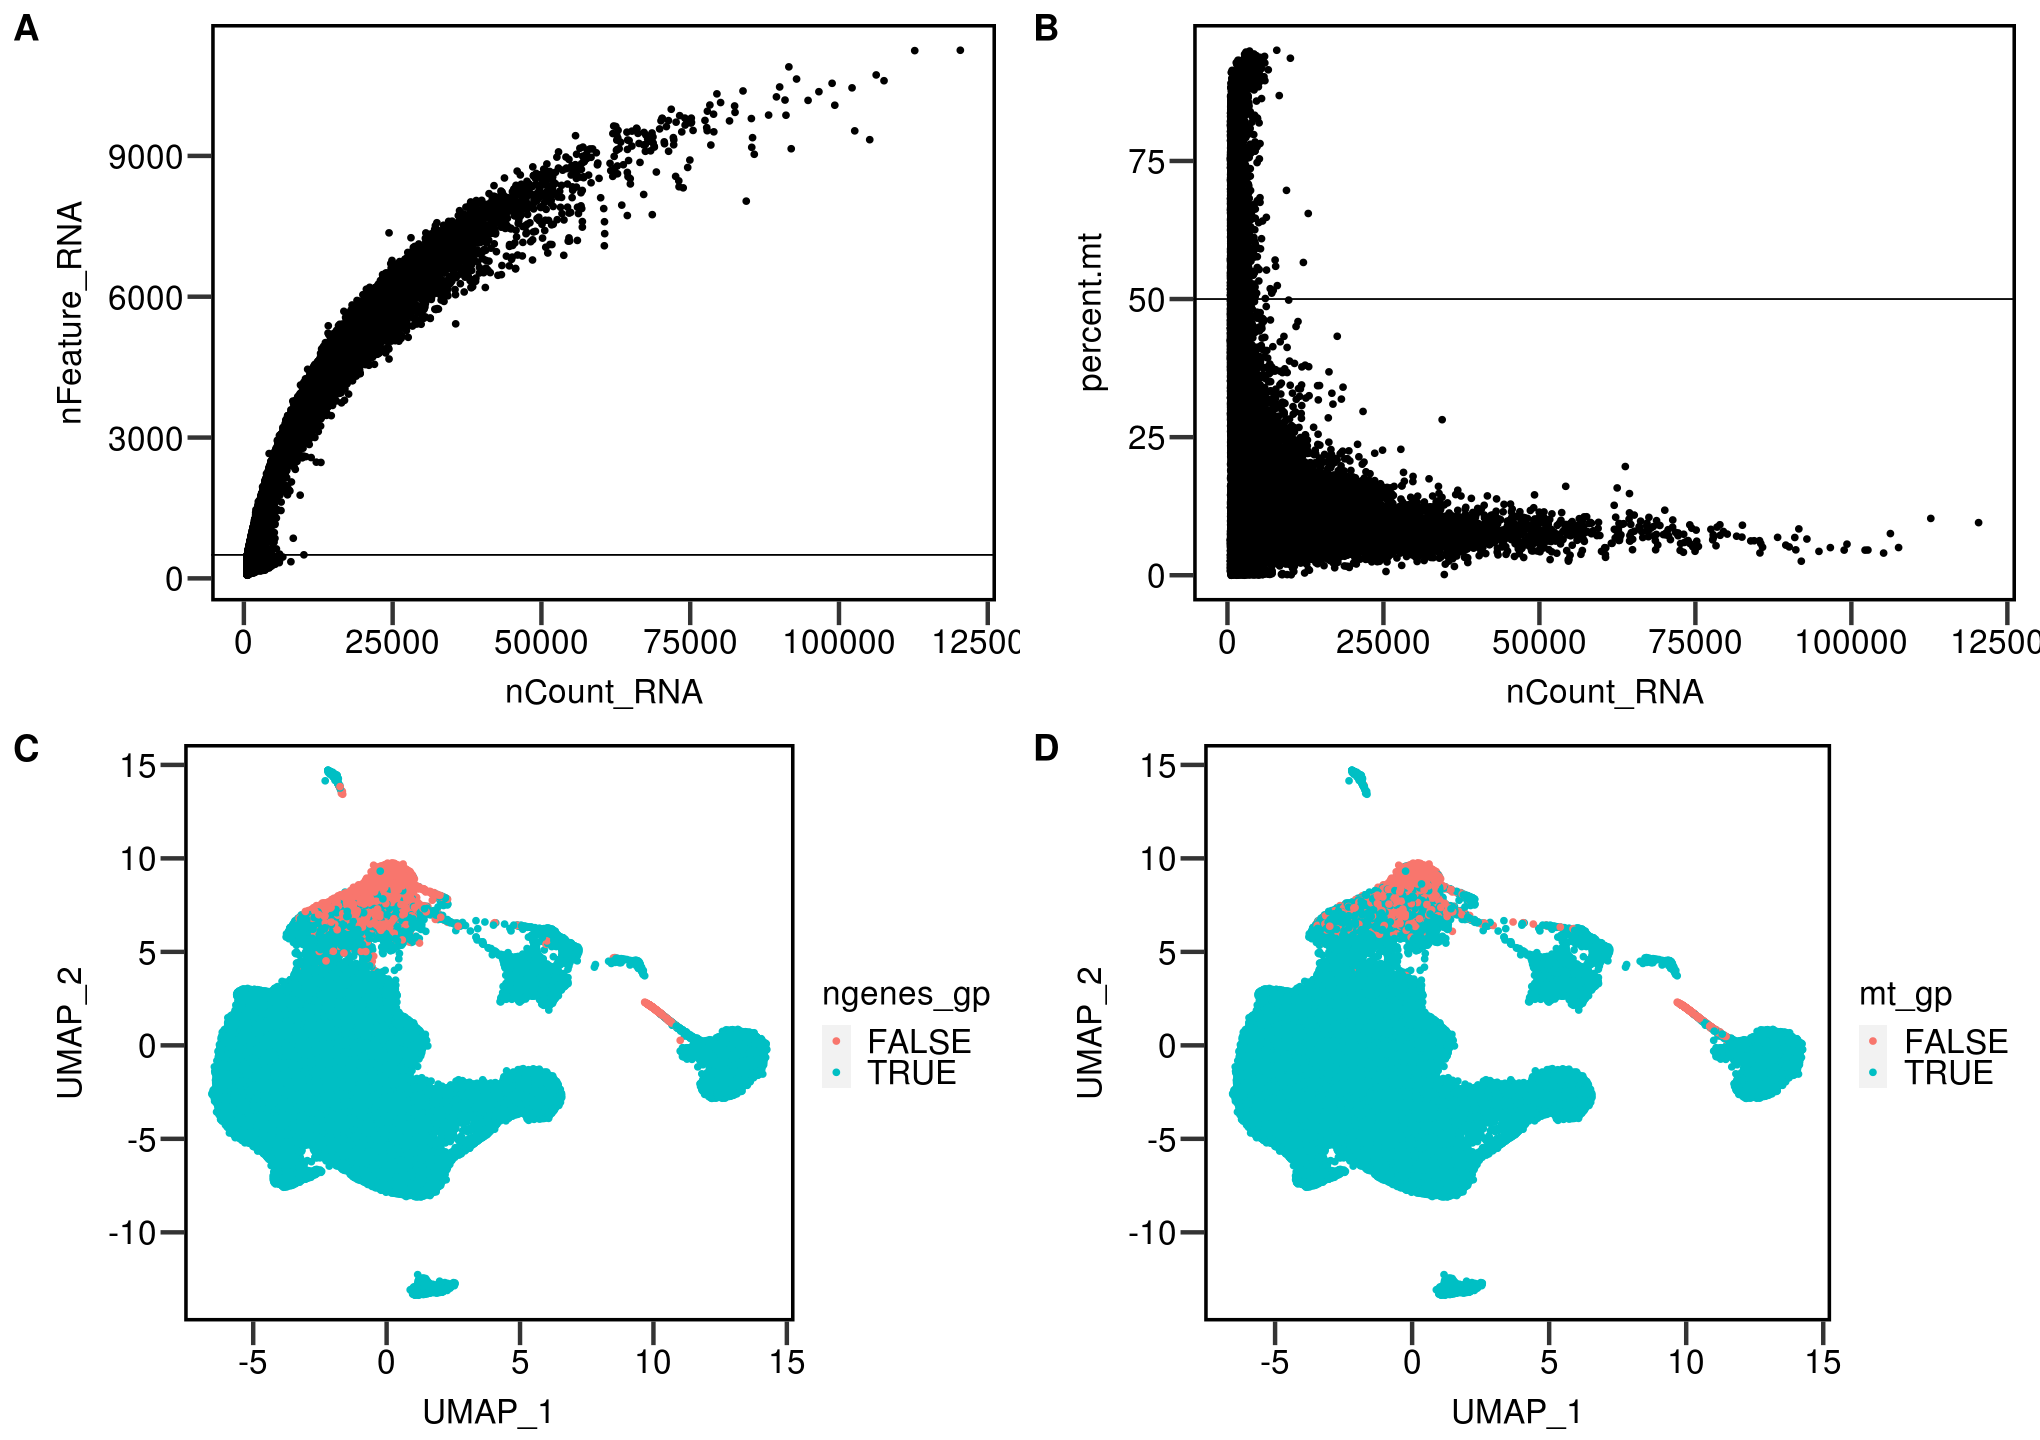

In [15]:
mt.thresh = 50
ngenes.thresh = 500

p1 = ggplot(meta, aes(x = nCount_RNA, y = nFeature_RNA)) + geom_point() + jn_theme + geom_hline(yintercept = ngenes.thresh)
p2 = ggplot(meta, aes(x = nCount_RNA, y = percent.mt)) + geom_point() + jn_theme + geom_hline(yintercept = mt.thresh)
head(meta)

meta$ngenes_gp = ifelse(meta$nFeature_RNA > ngenes.thresh, TRUE, FALSE)
meta$mt_gp = ifelse(meta$percent.mt > mt.thresh, FALSE, TRUE)

table(meta$ngenes_gp) / nrow(meta)
table(meta$mt_gp) / nrow(meta)

p3 = ggplot(meta, aes(x = UMAP_1, y = UMAP_2, color = ngenes_gp)) + geom_point() + jn_theme
p4 = ggplot(meta, aes(x = UMAP_1, y = UMAP_2, color = mt_gp)) + geom_point() + jn_theme

options(repr.plot.width = 17, repr.plot.height = 12)
plot_grid(p1, p2, p3, p4, labels = "AUTO", label_size = 22, nrow = 2) 

In [16]:
meta[,c("ngenes_gp", "mt_gp")] = NULL
integrated@meta.data = meta

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 99819
Number of edges: 3124735

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9590
Number of communities: 9
Elapsed time: 51 seconds


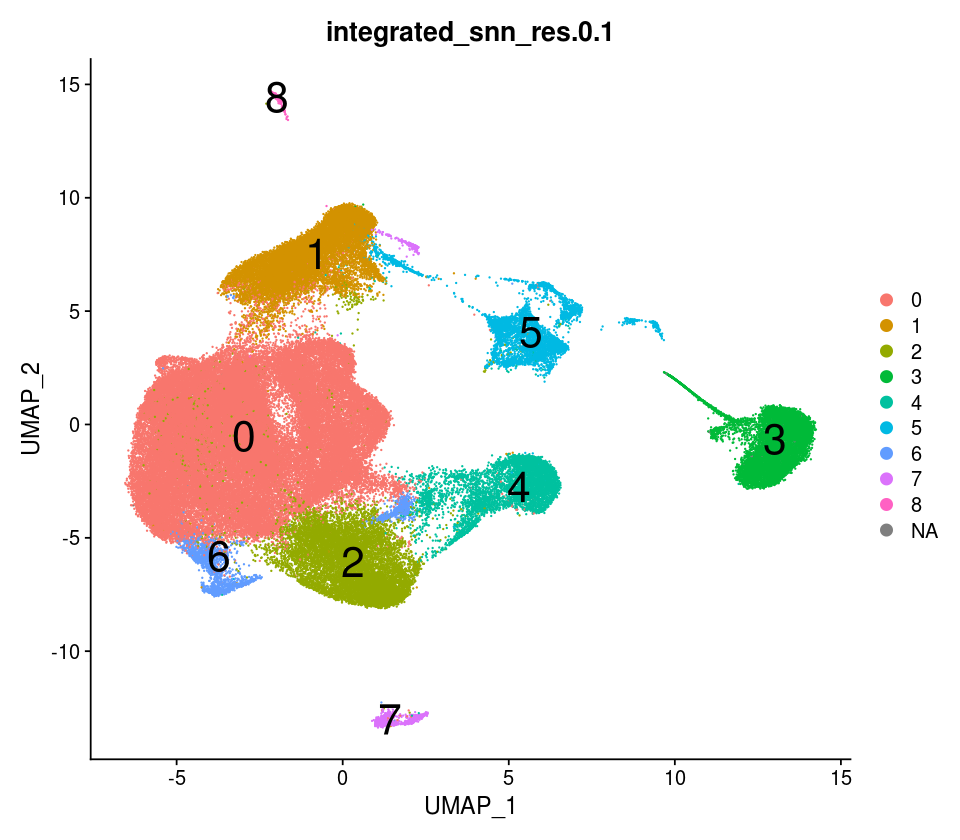

In [18]:
integrated = FindNeighbors(integrated, dims = 1:30)
integrated = FindClusters(integrated, resolution = 0.1)

options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(integrated, group.by = "integrated_snn_res.0.1", label = T, label.size = 9)




cells 2 remove: 11668

cells in cluster 1: 0



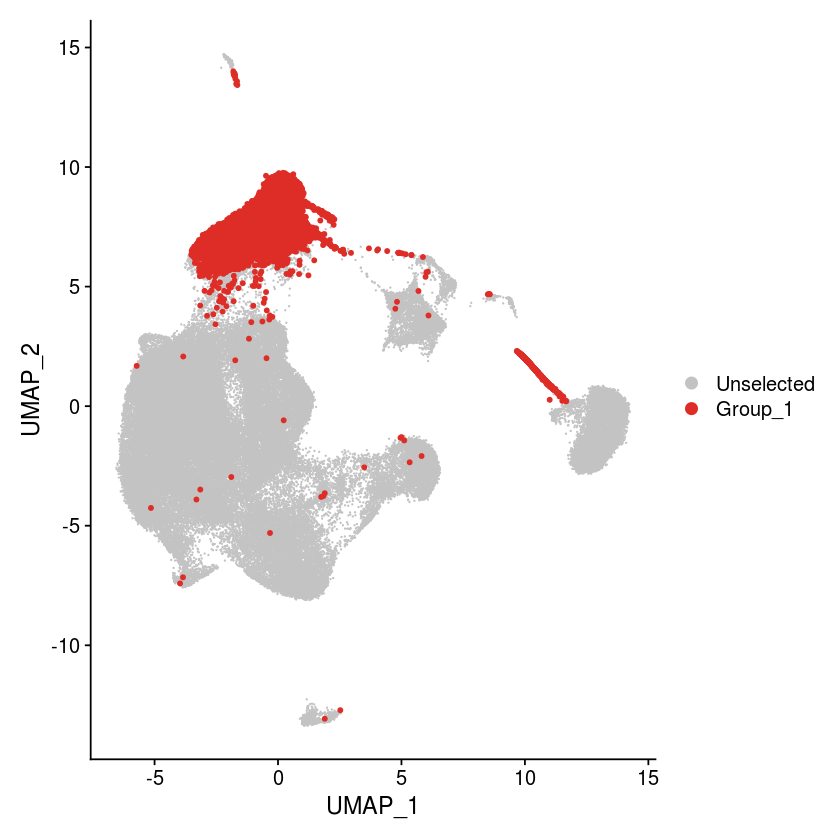

In [55]:
cells2remove = rownames(integrated@meta.data[integrated@meta.data$percent.mt > 50 | integrated@meta.data$nFeature_RNA < 500 ,])
cells2remove = c(cells2remove, rownames(integrated@meta.data[integrated@meta.data$integrated_snn_res.0.15 == 1,]))
# cells2remove = c(cells2remove, rownames(integrated@meta.data[integrated@meta.data$UMAP_2 < 10 & integrated@meta.data$UMAP_2 > 5 & integrated@meta.data$UMAP_1 < 4,]))

message(paste("cells 2 remove:", length(cells2remove)))
message(paste("cells in cluster 1:", length(unique(rownames(integrated@meta.data[integrated@meta.data$integrated_snn_res.0.15 == 1,])))))

options(repr.plot.height = 7, repr.plot.width = 7)
DimPlot(integrated, cells.highlight = cells2remove)



In [60]:
nrow(integrated@meta.data[rownames(integrated@meta.data) %in% cells2remove,])
nrow(integrated@meta.data)

integrated

ncol(GetAssayData(integrated, "data"))

[1] 11668

[1] 99753

An object of class Seurat 
64492 features across 99819 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

[1] 99819

In [56]:
subset(integrated, cells = rownames(integrated@meta.data[!rownames(integrated@meta.data) %in% cells2remove,]))

An object of class Seurat 
64492 features across 88030 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 88030
Number of edges: 2753349

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9550
Number of communities: 11
Elapsed time: 48 seconds


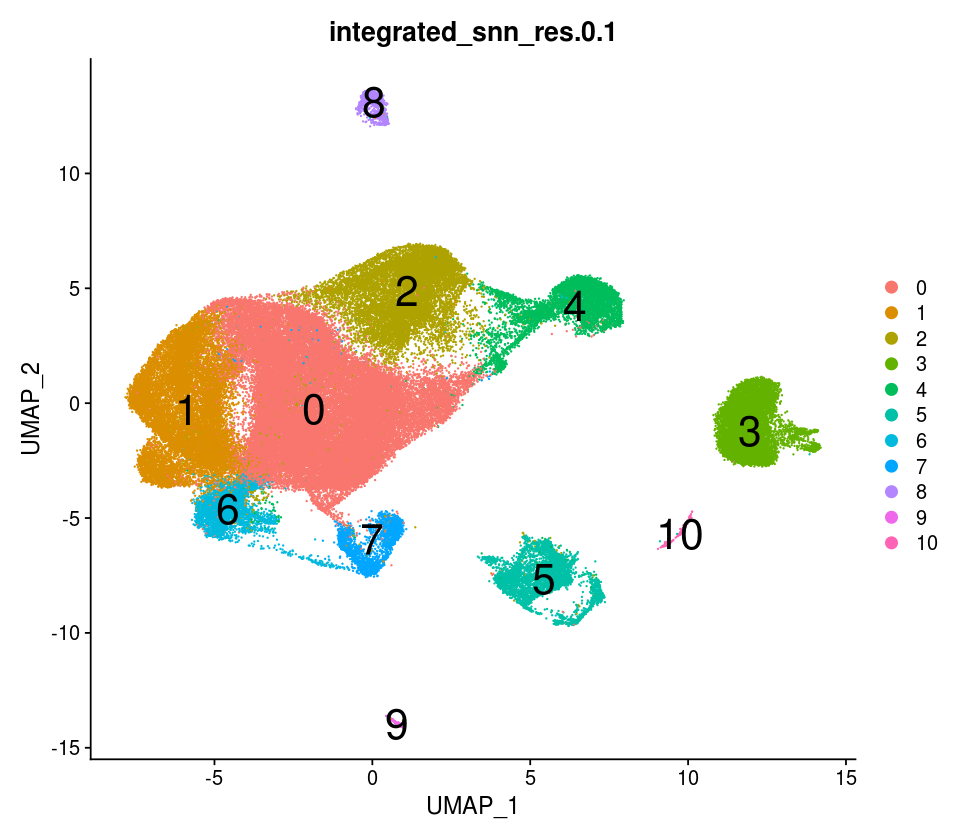

In [20]:
subset = subset(integrated, cells = rownames(integrated@meta.data[!rownames(integrated@meta.data) %in% cells2remove,]))

subset <- ScaleData(subset, verbose = FALSE)
subset <- RunPCA(subset, npcs = 30, verbose = FALSE)
subset <- RunUMAP(subset, reduction = "pca", dims = 1:30, verbose = F)

subset = FindNeighbors(subset, dims = 1:30)
subset = FindClusters(subset, resolution = 0.1)

options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(subset, group.by = "integrated_snn_res.0.1", label = T, label.size = 9)

In [54]:
integrated 

99819 - 11668

An object of class Seurat 
64492 features across 99819 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

[1] 88151

In [21]:
DefaultAssay(subset) = "RNA"

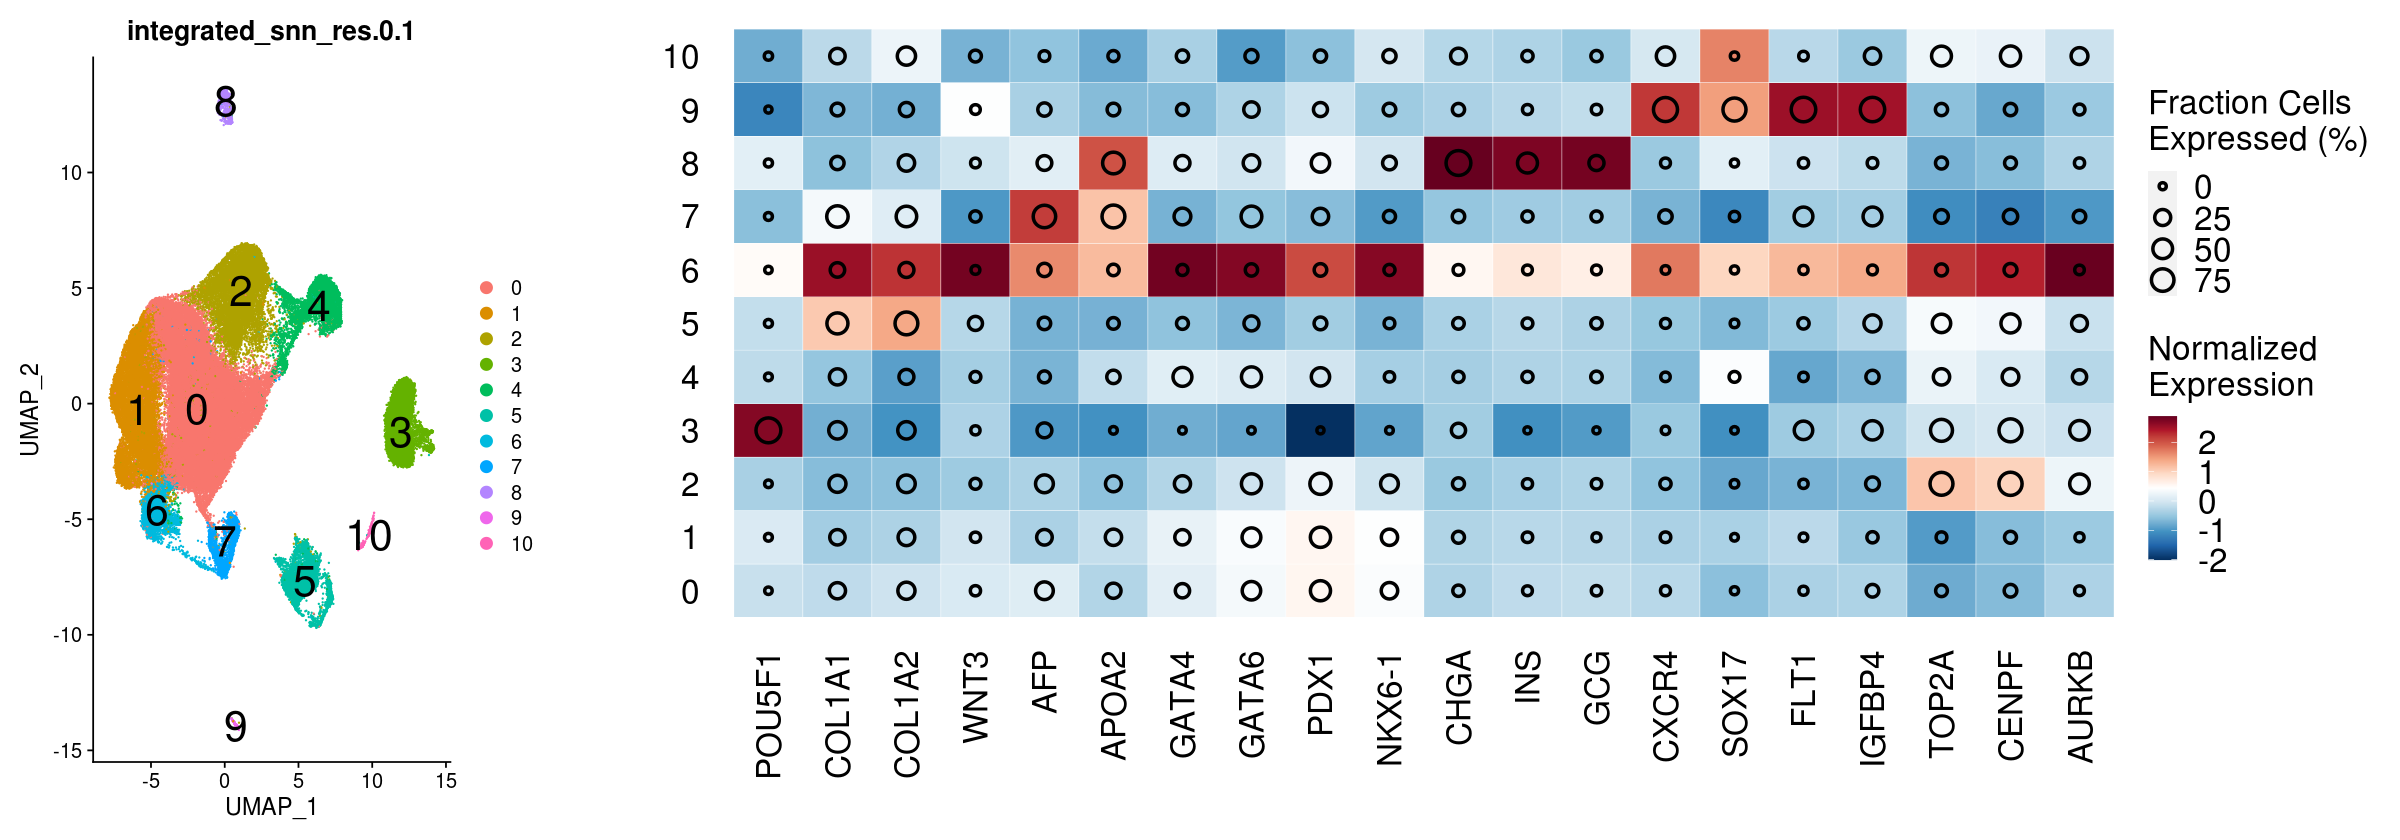

In [137]:
toplot = get_Zscores(subset@meta.data, GetAssayData(subset, "data"), "integrated_snn_res.0.1", unique(subset@meta.data$integrated_snn_res.0.1), genes)

col2 <- rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582",
               "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE",
               "#4393C3", "#2166AC", "#053061"))

options(repr.plot.height = 8, repr.plot.width = 20)
p1 = DimPlot(subset, group.by = "integrated_snn_res.0.1", label = T, label.size = 9)
p2 = ggplot(toplot, aes(x = gene, y = cluster, fill = znorm_exp)) + geom_tile(color = "white") + jn_theme + 
    scale_fill_gradientn(colors = col2, name = "Normalized\nExpression") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.ticks = element_blank(), panel.border = element_blank()) +
    xlab("") + ylab("") + geom_point(data = toplot, aes(x = gene, y = cluster, size = pct_exp), shape = 1, stroke = 1.5, ) +
    guides(size = guide_legend("Fraction Cells\nExpressed (%)"))

options(repr.plot.height = 7, repr.plot.width = 20)
plot_grid(p1, p2, nrow = 1, rel_widths = c(3, 10))

In [22]:
subset@meta.data[,c("UMAP_1", "UMAP_2")] = NULL
subset@meta.data = add_rownames(merge(subset@meta.data, Embeddings(subset, "umap"), by = "row.names"))

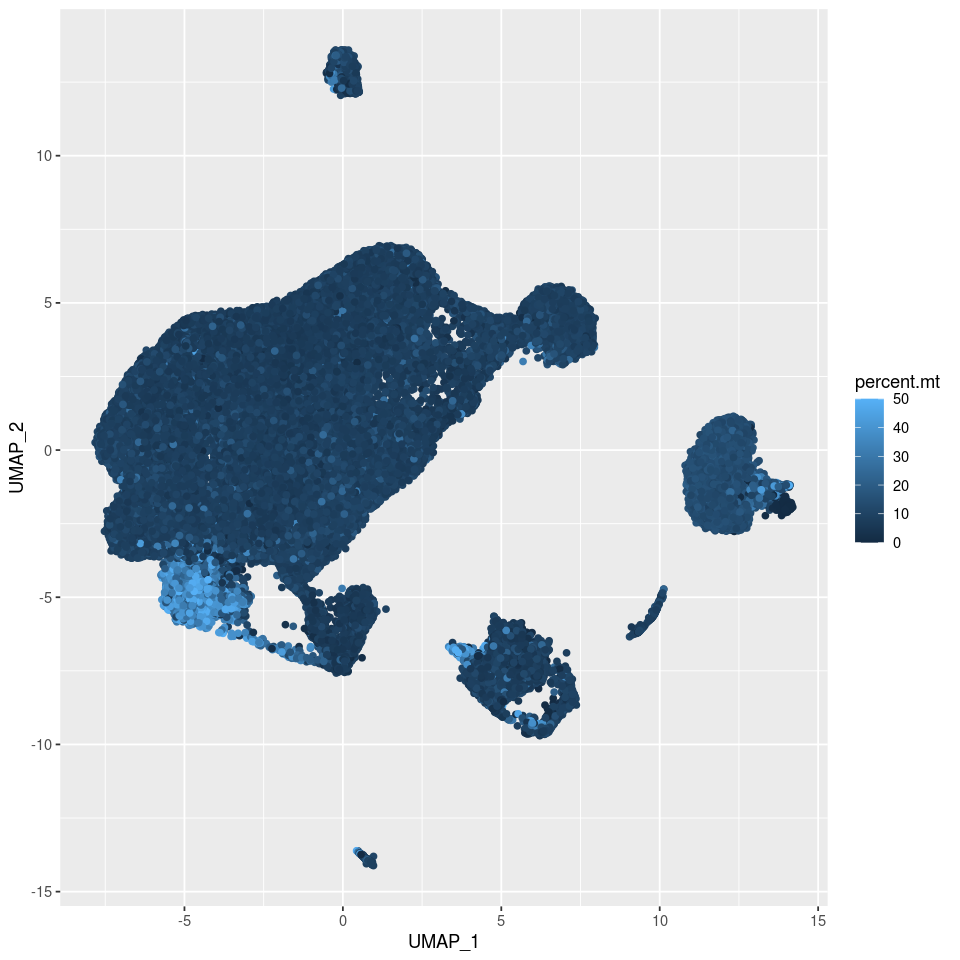

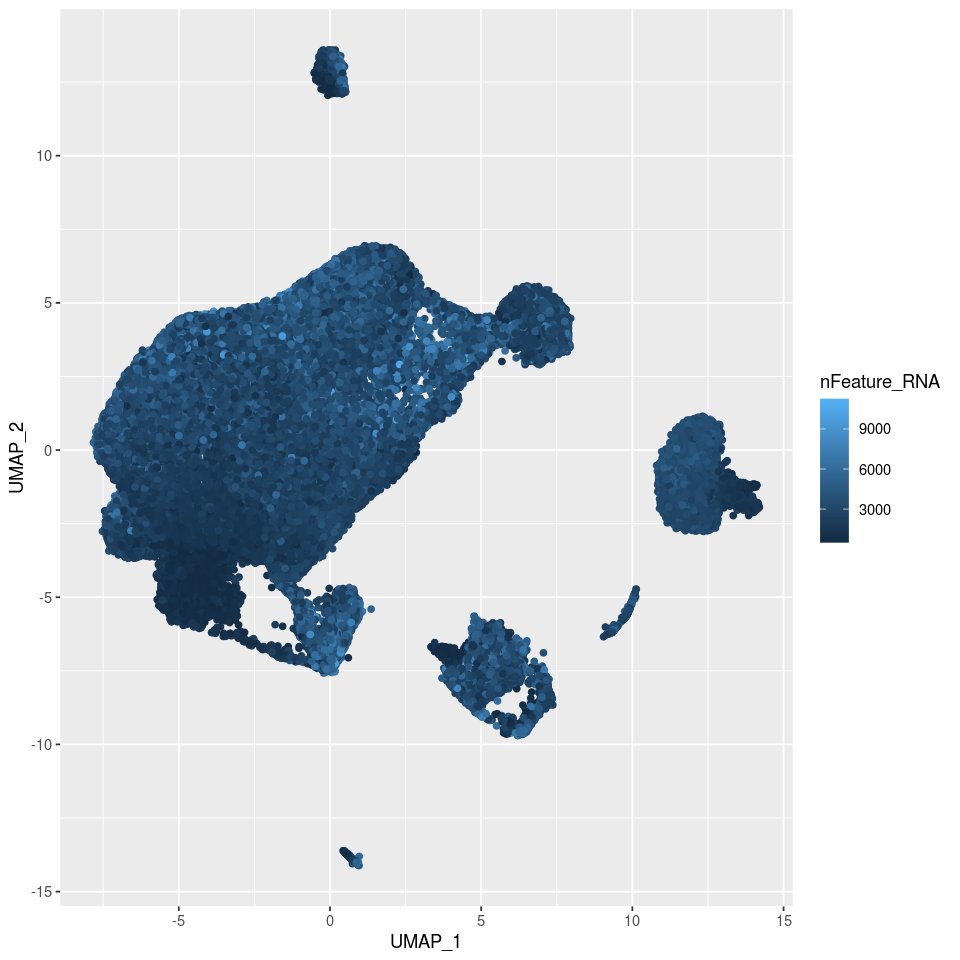

In [23]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot(subset@meta.data, aes( x = UMAP_1, y = UMAP_2, color = percent.mt)) + geom_point()
ggplot(subset@meta.data, aes( x = UMAP_1, y = UMAP_2, color = nFeature_RNA)) + geom_point()

# Add Demuxlet

In [24]:
demux1 = fread("/projects/PPC/pipeline/scRNA-Seq/sample/scRNA_10x_MIX_PPC_001/outs/demuxlet_common.best", data.table = F) %>% mutate(orig.ident = "mix1")
demux2 = fread("/projects/PPC/pipeline/scRNA-Seq/sample/scRNA_10X_MIX_PPC_002/outs/demuxlet_common.best", data.table = F) %>% mutate(orig.ident = "mix2")

demux = rbind(demux1, demux2)
head(demux,1)

,BARCODE,RD.TOTL,RD.PASS,RD.UNIQ,N.SNP,BEST,SNG.1ST,SNG.LLK1,SNG.2ND,SNG.LLK2,⋯,ALPHA,LLK12,LLK1,LLK2,LLK10,LLK20,LLK00,PRB.DBL,PRB.SNG1,orig.ident
,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,.,1864204,318456,287331,48938,DBL-c7a966f7-e22e-4807-afff-2bae9ca5fc72-916c0056-cef2-488f-ae44-cb9b1398669e-0.400,c7a966f7-e22e-4807-afff-2bae9ca5fc72,-68242.17,916c0056-cef2-488f-ae44-cb9b1398669e,-69633.34,⋯,0.4,-36949.17,-68242.17,-69633.34,-43578.91,-41191.56,-31400.44,1,NaN,mix1


In [25]:
meta = subset@meta.data
sample_meta = fread(paste("1.Metadata", "subject_sample_metadata.txt", sep = "/"), data.table = F)



In [26]:
wgs = sample_meta[sample_meta$data_type == "WGS",c("Subject_UUID", "Sample_UUID")]
colnames(wgs) = c("Subject_UUID", "wgs_uuid")
rna = sample_meta[sample_meta$data_type == "RNA-seq",c("Subject_UUID", "Sample_UUID", "UDID", "Cell_type")]
colnames(rna) = c("Subject_UUID", "rna_uuid", "UDID", "Cell_type")
wgs2rna = unique(merge(wgs, rna, by = "Subject_UUID"))
# fwrite(wgs2rna, paste("1.Metadata", "RNA_id.map", sep = "/"), row.names = F, sep = "\t")
wgs2rna

,Subject_UUID,wgs_uuid,rna_uuid,UDID,Cell_type
,<chr>,<chr>,<chr>,<chr>,<chr>
1,5f5c5255-f41b-46eb-a9bd-7130515e3efc,4f63a2f0-b270-48f8-8603-38d0de2bec74,cbbd5fb8-217c-4cbb-b15b-6962d0fae2c6,PPC_051,PPC
2,725e0255-424c-44da-86c9-bc0bc14a21a8,916c0056-cef2-488f-ae44-cb9b1398669e,0145d765-79e3-4234-b6e7-fa52969a47dd,PPC_023,PPC
3,7cf9e7b2-28a3-4b42-812b-929516fbce4a,4df98c9a-93f7-4735-80c8-24b1e8943549,a1f72a69-ef58-40bf-8b87-fd497e1ea5bf,PPC_030,PPC
4,90e8222f-2a97-4a3c-9517-fbd7626122fd,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,a33e63ce-0637-4177-b8e3-0c4851c308c4,PPC_036,PPC
5,90e8222f-2a97-4a3c-9517-fbd7626122fd,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,90681c57-4b83-4822-ae79-6c4cd29f0396,PPC_029,PPC
8,9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,c7a966f7-e22e-4807-afff-2bae9ca5fc72,07e2ab6e-0032-4a42-97d4-e7087017ec8d,PPC_027,PPC
9,a140d6d1-9fbf-4645-a083-b870bf2f0f67,2302e931-a8d5-454d-83cf-f86e41c1e901,ccd9879b-98cf-418d-8348-af74807e9432,PPC_134,PPC
10,b48d5663-b599-4d02-a70b-6bd12546041f,0a1bcb9c-aa08-4f75-b564-ff7abc75235c,fcdfdab4-173b-4afb-bc24-5e94e97890cf,PPC_150,PPC
11,c3bb6245-5d1b-4dbc-8b16-b0ca47472e91,ee146263-82f5-4ed7-bb49-4300837acc85,dc5017d7-de77-45ae-8ecf-12b66ec50631,PPC_028,PPC


In [27]:
wgs = sample_meta[sample_meta$data_type == "WGS",c("Subject_UUID", "Sample_UUID")]
colnames(wgs) = c("Subject_UUID", "wgs_uuid")
rna = sample_meta[sample_meta$data_type == "scRNA-seq (Live)",c("Subject_UUID", "Sample_UUID", "UDID", "Cell_type")]
colnames(rna) = c("Subject_UUID", "rna_uuid", "UDID", "Cell_type")
wgs2rna = unique(merge(wgs, rna, by = "Subject_UUID"))
wgs2rna

aggr = meta[meta$orig.ident %like% "aggr",]
colnames(aggr)[4] = "BARCODE"
aggr$aggr_id = unlist(lapply(rownames(aggr), function(x) { unlist(strsplit(unlist(strsplit(x, "-"))[2], "_"))[1] }))
aggr_meta = fread("/projects/PPC/pipeline/scRNA-Seq/sample/aggr_individual/outs/aggr.csv", data.table = F, sep = ",")
aggr_meta$aggr_id = c(1:nrow(aggr_meta))
aggr$rna_uuid = suppressMessages(mapvalues(aggr$aggr_id, from = aggr_meta$aggr_id, to = aggr_meta$sample_id))
aggr[,c("SNG.1ST", "SNG.LLK1", "SNG.LLK2", "SNG.2ND","orig.ident", "BEST")] = NA
aggr$sample_type = "Live"
aggr$udid = suppressMessages(mapvalues(aggr$rna_uuid, from = wgs2rna$rna_uuid, to = wgs2rna$UDID))
aggr$wgs_uuid = suppressMessages(mapvalues(aggr$udid, from = wgs2rna$UDID, to = wgs2rna$wgs_uuid))
aggr$subject_uuid = suppressMessages(mapvalues(aggr$udid, from = wgs2rna$UDID, to = wgs2rna$Subject_UUID))
aggr$orig.ident = "aggr"

,Subject_UUID,wgs_uuid,rna_uuid,UDID,Cell_type
,<chr>,<chr>,<chr>,<chr>,<chr>
1,5f5c5255-f41b-46eb-a9bd-7130515e3efc,4f63a2f0-b270-48f8-8603-38d0de2bec74,,PPC_051,PPC
2,725e0255-424c-44da-86c9-bc0bc14a21a8,916c0056-cef2-488f-ae44-cb9b1398669e,fb6028d0-5ef0-4f53-bf73-da3983948ce1,PPC_023,PPC
3,7cf9e7b2-28a3-4b42-812b-929516fbce4a,4df98c9a-93f7-4735-80c8-24b1e8943549,4fd8f0f0-2356-451c-a61f-c30610f1141c,PPC_030,PPC
4,90e8222f-2a97-4a3c-9517-fbd7626122fd,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,eada4dfd-14cc-4767-8791-4a478eb3fe12,PPC_036,PPC
5,90e8222f-2a97-4a3c-9517-fbd7626122fd,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,4efdab78-1eda-4888-8483-15b519c375dc,PPC_029,PPC
8,9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,c7a966f7-e22e-4807-afff-2bae9ca5fc72,7d700751-e80d-40b6-9e79-0efec5ae5a80,PPC_027,PPC
9,a140d6d1-9fbf-4645-a083-b870bf2f0f67,2302e931-a8d5-454d-83cf-f86e41c1e901,,PPC_134,PPC
10,b48d5663-b599-4d02-a70b-6bd12546041f,0a1bcb9c-aa08-4f75-b564-ff7abc75235c,,PPC_150,PPC
11,c3bb6245-5d1b-4dbc-8b16-b0ca47472e91,ee146263-82f5-4ed7-bb49-4300837acc85,e2308d3d-f183-44e4-b0b7-2dff4a5006da,PPC_028,PPC


In [48]:
wgs = sample_meta[sample_meta$data_type == "WGS",c("Subject_UUID", "Sample_UUID")]
colnames(wgs) = c("Subject_UUID", "wgs_uuid")
rna = sample_meta[sample_meta$data_type == "scRNA-seq (Cryopreserved)" & sample_meta[,"Pool Scheme"] != "",c("Subject_UUID", "Sample_UUID", "UDID")]
colnames(rna) = c("Subject_UUID", "rna_uuid", "UDID")
wgs2rna = unique(merge(wgs, rna, by = "Subject_UUID"))
wgs2rna

mix  = meta[!meta$orig.ident %like% "aggr",]
colnames(mix)[4] = "BARCODE"
mix$orig.ident = ifelse(mix$orig.ident %like% "001", "mix1", "mix2")
mix = merge(mix, demux[,c("SNG.1ST", "SNG.2ND", "BARCODE", "orig.ident", "SNG.LLK1", "SNG.LLK2", "BEST")], by = c("BARCODE", "orig.ident"))
mix$sample_type = "Cryo"
mix$wgs_uuid = mix$SNG.1ST

data.table(table(mix[mix$orig.ident == "mix1",]$wgs_uuid))

mix$wgs_uuid = ifelse(mix$wgs_uuid %in% c("4df98c9a-93f7-4735-80c8-24b1e8943549", "ee146263-82f5-4ed7-bb49-4300837acc85"), mix$SNG.2ND, mix$SNG.1ST)
mix$subject_uuid = suppressMessages(mapvalues(mix$wgs_uuid, from = wgs2rna$wgs_uuid, to = wgs2rna$Subject_UUID))
mix$udid = suppressMessages(mapvalues(mix$subject_uuid, from = wgs2rna$Subject_UUID, to = wgs2rna$UDID))
mix$aggr_id = NA
mix$rna_uuid = suppressMessages(mapvalues(mix$udid, from = wgs2rna$UDID, to = wgs2rna$rna_uuid))

rownames(mix) = mix$seurat_id

,Subject_UUID,wgs_uuid,rna_uuid,UDID
,<chr>,<chr>,<chr>,<chr>
1,5f5c5255-f41b-46eb-a9bd-7130515e3efc,4f63a2f0-b270-48f8-8603-38d0de2bec74,8f38fc74-ec4a-4014-8462-6e10e018f4c3,PPC_051
2,725e0255-424c-44da-86c9-bc0bc14a21a8,916c0056-cef2-488f-ae44-cb9b1398669e,04cd9285-b478-468a-a055-a9d82c99b016,PPC_023
3,90e8222f-2a97-4a3c-9517-fbd7626122fd,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,04cd9285-b478-468a-a055-a9d82c99b016,PPC_029
5,9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,c7a966f7-e22e-4807-afff-2bae9ca5fc72,04cd9285-b478-468a-a055-a9d82c99b016,PPC_027
6,a140d6d1-9fbf-4645-a083-b870bf2f0f67,2302e931-a8d5-454d-83cf-f86e41c1e901,8f38fc74-ec4a-4014-8462-6e10e018f4c3,PPC_134
7,b48d5663-b599-4d02-a70b-6bd12546041f,0a1bcb9c-aa08-4f75-b564-ff7abc75235c,8f38fc74-ec4a-4014-8462-6e10e018f4c3,PPC_150
8,eb1309e6-5567-437b-82d7-549c1c8d5493,ac69bd1c-2131-4391-a2ee-b6c19b219c07,04cd9285-b478-468a-a055-a9d82c99b016,PPC_034


V1,N
<chr>,<int>
0a1bcb9c-aa08-4f75-b564-ff7abc75235c,11
2302e931-a8d5-454d-83cf-f86e41c1e901,10
4df98c9a-93f7-4735-80c8-24b1e8943549,7
4f63a2f0-b270-48f8-8603-38d0de2bec74,8
916c0056-cef2-488f-ae44-cb9b1398669e,3320
9bff6491-20c4-410a-98f6-4b4ee6aaf97d,2624
ac69bd1c-2131-4391-a2ee-b6c19b219c07,2036
c7a966f7-e22e-4807-afff-2bae9ca5fc72,3638
ee146263-82f5-4ed7-bb49-4300837acc85,14


In [30]:
nmeta = rbind(aggr, mix)
rownames(nmeta) = nmeta$seurat_id

In [31]:
nrow(nmeta)
nrow(subset@meta.data)

[1] 88030

[1] 88030

In [32]:
obj = subset
obj@meta.data = nmeta

In [33]:
table(obj@meta.data$orig.ident)


 aggr  mix1  mix2 
67922 11668  8440 

In [42]:
sample_map = fread(paste("~/jn_projects/ppc_pilot/pipeline", "1.Metadata", "sample.map", sep = "/"), data.table = F)
sample_map

subject_uuid,udid,sample_uuid.wgs,sample_uuid.rna,sample_uuid.scrna_live,sample_uuid.scrna_cryo,sample_uuid.snatac_cryp,sample_uuid.atac
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
eb1309e6-5567-437b-82d7-549c1c8d5493,iPSC-PPC_034,ac69bd1c-2131-4391-a2ee-b6c19b219c07,672cb8f3-f2b6-4429-9f80-29bea3cb0b45,3ab5e63d-1d2d-441b-b1c3-7f77fd86e4dd,,,
725e0255-424c-44da-86c9-bc0bc14a21a8,PPC_023,916c0056-cef2-488f-ae44-cb9b1398669e,0145d765-79e3-4234-b6e7-fa52969a47dd,fb6028d0-5ef0-4f53-bf73-da3983948ce1,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,a4b4d7a6-3f9c-4cfb-9272-47e1b99aee4a
9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,PPC_027,c7a966f7-e22e-4807-afff-2bae9ca5fc72,07e2ab6e-0032-4a42-97d4-e7087017ec8d,7d700751-e80d-40b6-9e79-0efec5ae5a80,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,818b7c8b-b314-4585-b61c-4861c4e64356
c3bb6245-5d1b-4dbc-8b16-b0ca47472e91,PPC_028,ee146263-82f5-4ed7-bb49-4300837acc85,dc5017d7-de77-45ae-8ecf-12b66ec50631,e2308d3d-f183-44e4-b0b7-2dff4a5006da,,,
90e8222f-2a97-4a3c-9517-fbd7626122fd,PPC_029,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,90681c57-4b83-4822-ae79-6c4cd29f0396,4efdab78-1eda-4888-8483-15b519c375dc,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,6e90a536-9cf9-4b2d-99ce-40185d18016a
7cf9e7b2-28a3-4b42-812b-929516fbce4a,PPC_030,4df98c9a-93f7-4735-80c8-24b1e8943549,a1f72a69-ef58-40bf-8b87-fd497e1ea5bf,4fd8f0f0-2356-451c-a61f-c30610f1141c,,,
eb1309e6-5567-437b-82d7-549c1c8d5493,PPC_034,ac69bd1c-2131-4391-a2ee-b6c19b219c07,26e5563e-8dc0-4045-b82c-6e7d012756c1,1eeda2ea-453a-4ff4-9cae-2a68f823d919,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,ec76959e-1786-4e8b-be46-6359f264d47d
90e8222f-2a97-4a3c-9517-fbd7626122fd,PPC_036,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,a33e63ce-0637-4177-b8e3-0c4851c308c4,eada4dfd-14cc-4767-8791-4a478eb3fe12,,,
5f5c5255-f41b-46eb-a9bd-7130515e3efc,PPC_051,4f63a2f0-b270-48f8-8603-38d0de2bec74,cbbd5fb8-217c-4cbb-b15b-6962d0fae2c6,,8f38fc74-ec4a-4014-8462-6e10e018f4c3,7a4c28c8-a2be-4370-b258-d05c27569928,


In [43]:
a = data.frame(table(obj@meta.data[obj@meta.data$orig.ident != "aggr",]$rna_uuid, obj@meta.data[obj@meta.data$orig.ident != "aggr",]$subject_uuid))

a[a$Var1 %like% "04cd",]

,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,04cd9285-b478-468a-a055-a9d82c99b016,5f5c5255-f41b-46eb-a9bd-7130515e3efc,0
4,04cd9285-b478-468a-a055-a9d82c99b016,725e0255-424c-44da-86c9-bc0bc14a21a8,3333
7,04cd9285-b478-468a-a055-a9d82c99b016,90e8222f-2a97-4a3c-9517-fbd7626122fd,2645
10,04cd9285-b478-468a-a055-a9d82c99b016,9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,3655
13,04cd9285-b478-468a-a055-a9d82c99b016,a140d6d1-9fbf-4645-a083-b870bf2f0f67,0
16,04cd9285-b478-468a-a055-a9d82c99b016,b48d5663-b599-4d02-a70b-6bd12546041f,0
19,04cd9285-b478-468a-a055-a9d82c99b016,eb1309e6-5567-437b-82d7-549c1c8d5493,2049
22,04cd9285-b478-468a-a055-a9d82c99b016,ee146263-82f5-4ed7-bb49-4300837acc85,0


# Remove mitochondrial

cells2remove: 3834



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1471 23.6843 33.9746 31.5702 41.7155 50.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  500.0   594.0   723.0   814.8   920.0  4309.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   6.958   8.392   9.356  10.529  49.953 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500    2055    2775    2967    3590   11250 

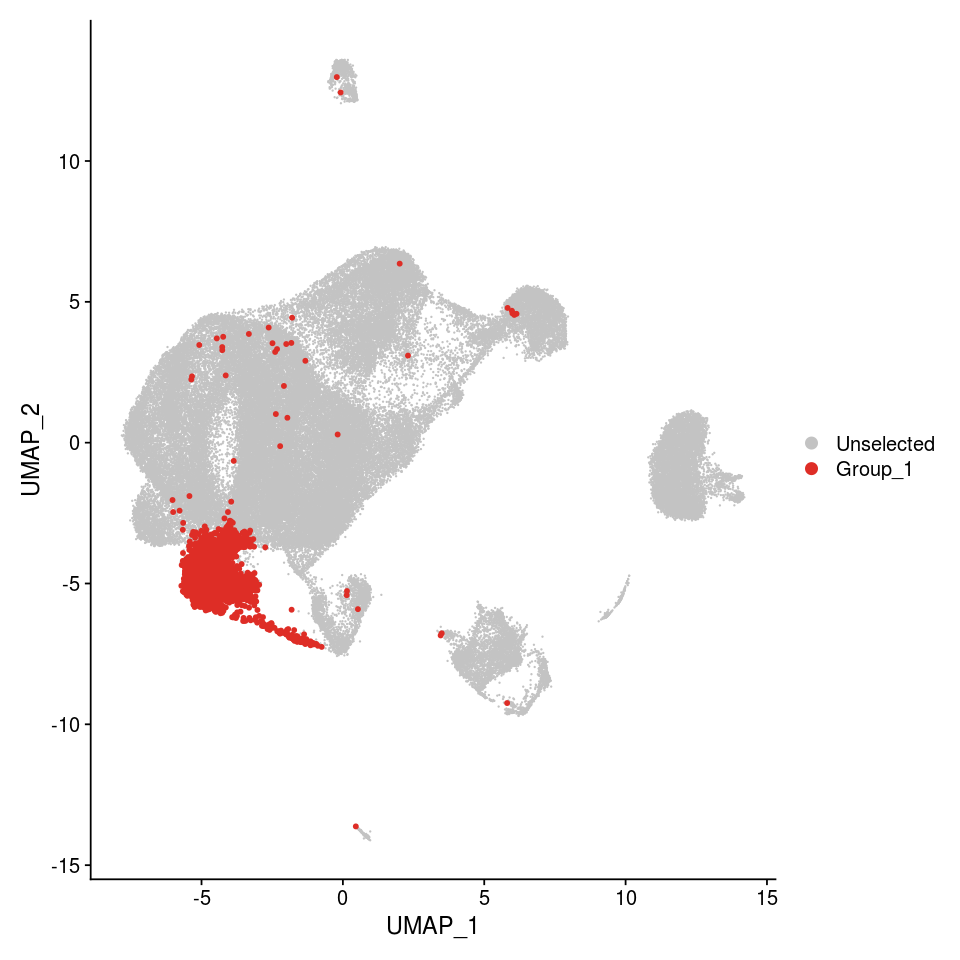

In [38]:
cells2remove = rownames(obj@meta.data[obj@meta.data$integrated_snn_res.0.1 == 6,])

message(paste("cells2remove:", length(unique(cells2remove))))

summary(obj@meta.data[cells2remove,]$percent.mt)
summary(obj@meta.data[cells2remove,]$nFeature_RNA)

summary(obj@meta.data[!rownames(obj@meta.data) %in% cells2remove,]$percent.mt)
summary(obj@meta.data[!rownames(obj@meta.data) %in% cells2remove,]$nFeature_RNA)

DimPlot(obj, cells.highlight = cells2remove)

In [163]:
DefaultAssay(obj) = "integrated"

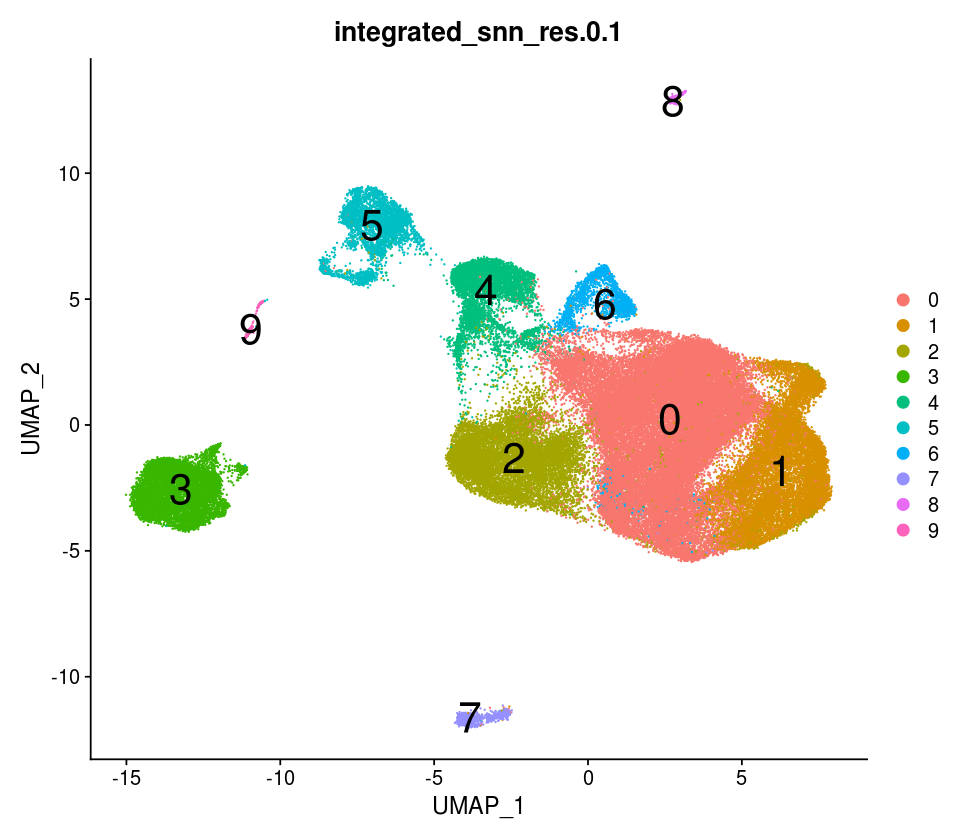

In [174]:
nobj = subset(obj, cells = rownames(obj@meta.data[!rownames(obj@meta.data) %in% cells2remove,]))

nobj <- ScaleData(nobj, verbose = FALSE)
nobj <- RunPCA(nobj, npcs = 50, verbose = FALSE)
nobj <- RunUMAP(nobj, reduction = "pca", dims = 1:50, verbose = F, n.neighbors = 35)
#30, 10
#50, 15/20

nobj = FindNeighbors(nobj, dims = 1:30)
nobj = FindClusters(nobj, resolution = 0.1)

options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(nobj, group.by = "integrated_snn_res.0.1", label = T, label.size = 9)

In [175]:
save(nobj, file = paste("2.scRNA_seq", "integrated_filtered_cleana.robj", sep = "/"))

In [110]:
load(paste("2.scRNA_seq", "integrated_filtered_cleana.robj", sep = "/"), verbose = T)

Loading objects:
  nobj


In [111]:
nobj

An object of class Seurat 
64492 features across 83971 samples within 2 assays 
Active assay: RNA (62492 features, 0 variable features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

# Violin Plots

In [2]:
load(paste("2.scRNA_seq", "integrated_filtered_cleana.robj", sep = "/"), verbose = T)

Loading objects:
  nobj


In [112]:
sample_map = fread(paste("~/jn_projects/ppc_pilot/pipeline", "1.Metadata", "sample.map", sep = "/"), data.table = F)
sample_map

subject_uuid,udid,sample_uuid.wgs,sample_uuid.rna,sample_uuid.scrna_live,sample_uuid.scrna_cryo,sample_uuid.snatac_cryp,sample_uuid.atac
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
eb1309e6-5567-437b-82d7-549c1c8d5493,iPSC-PPC_034,ac69bd1c-2131-4391-a2ee-b6c19b219c07,672cb8f3-f2b6-4429-9f80-29bea3cb0b45,3ab5e63d-1d2d-441b-b1c3-7f77fd86e4dd,,,
725e0255-424c-44da-86c9-bc0bc14a21a8,PPC_023,916c0056-cef2-488f-ae44-cb9b1398669e,0145d765-79e3-4234-b6e7-fa52969a47dd,fb6028d0-5ef0-4f53-bf73-da3983948ce1,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,a4b4d7a6-3f9c-4cfb-9272-47e1b99aee4a
9d988cb0-01b1-4d5d-bf4b-3fd3baf149a4,PPC_027,c7a966f7-e22e-4807-afff-2bae9ca5fc72,07e2ab6e-0032-4a42-97d4-e7087017ec8d,7d700751-e80d-40b6-9e79-0efec5ae5a80,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,818b7c8b-b314-4585-b61c-4861c4e64356
c3bb6245-5d1b-4dbc-8b16-b0ca47472e91,PPC_028,ee146263-82f5-4ed7-bb49-4300837acc85,dc5017d7-de77-45ae-8ecf-12b66ec50631,e2308d3d-f183-44e4-b0b7-2dff4a5006da,,,
90e8222f-2a97-4a3c-9517-fbd7626122fd,PPC_029,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,90681c57-4b83-4822-ae79-6c4cd29f0396,4efdab78-1eda-4888-8483-15b519c375dc,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,6e90a536-9cf9-4b2d-99ce-40185d18016a
7cf9e7b2-28a3-4b42-812b-929516fbce4a,PPC_030,4df98c9a-93f7-4735-80c8-24b1e8943549,a1f72a69-ef58-40bf-8b87-fd497e1ea5bf,4fd8f0f0-2356-451c-a61f-c30610f1141c,,,
eb1309e6-5567-437b-82d7-549c1c8d5493,PPC_034,ac69bd1c-2131-4391-a2ee-b6c19b219c07,26e5563e-8dc0-4045-b82c-6e7d012756c1,1eeda2ea-453a-4ff4-9cae-2a68f823d919,04cd9285-b478-468a-a055-a9d82c99b016,83b3e7ac-0e82-4bef-8648-2ece13090551,ec76959e-1786-4e8b-be46-6359f264d47d
90e8222f-2a97-4a3c-9517-fbd7626122fd,PPC_036,9bff6491-20c4-410a-98f6-4b4ee6aaf97d,a33e63ce-0637-4177-b8e3-0c4851c308c4,eada4dfd-14cc-4767-8791-4a478eb3fe12,,,
5f5c5255-f41b-46eb-a9bd-7130515e3efc,PPC_051,4f63a2f0-b270-48f8-8603-38d0de2bec74,cbbd5fb8-217c-4cbb-b15b-6962d0fae2c6,,8f38fc74-ec4a-4014-8462-6e10e018f4c3,7a4c28c8-a2be-4370-b258-d05c27569928,


In [118]:
m1_subjects = sample_map[sample_map$sample_uuid.scrna_cryo %like% "04cd",]$sample_uuid.wgs
m2_subjects = sample_map[sample_map$sample_uuid.scrna_cryo %like% "8f38",]$sample_uuid.wgs

m1 = data.frame(table(nobj@meta.data[nobj@meta.data$orig.ident == "mix1",]$wgs_uuid, nobj@meta.data[nobj@meta.data$orig.ident == "mix1",]$rna_uuid))
m2 = data.frame(table(nobj@meta.data[nobj@meta.data$orig.ident == "mix2",]$wgs_uuid, nobj@meta.data[nobj@meta.data$orig.ident == "mix2",]$rna_uuid))

nrow(nobj@meta.data[nobj@meta.data$orig.ident == "mix1" & !nobj@meta.data$wgs_uuid %in% m1_subjects,])
nrow(nobj@meta.data[nobj@meta.data$orig.ident == "mix2" & !nobj@meta.data$wgs_uuid %in% m2_subjects,])


13 + 10

[1] 13

[1] 10

[1] 23

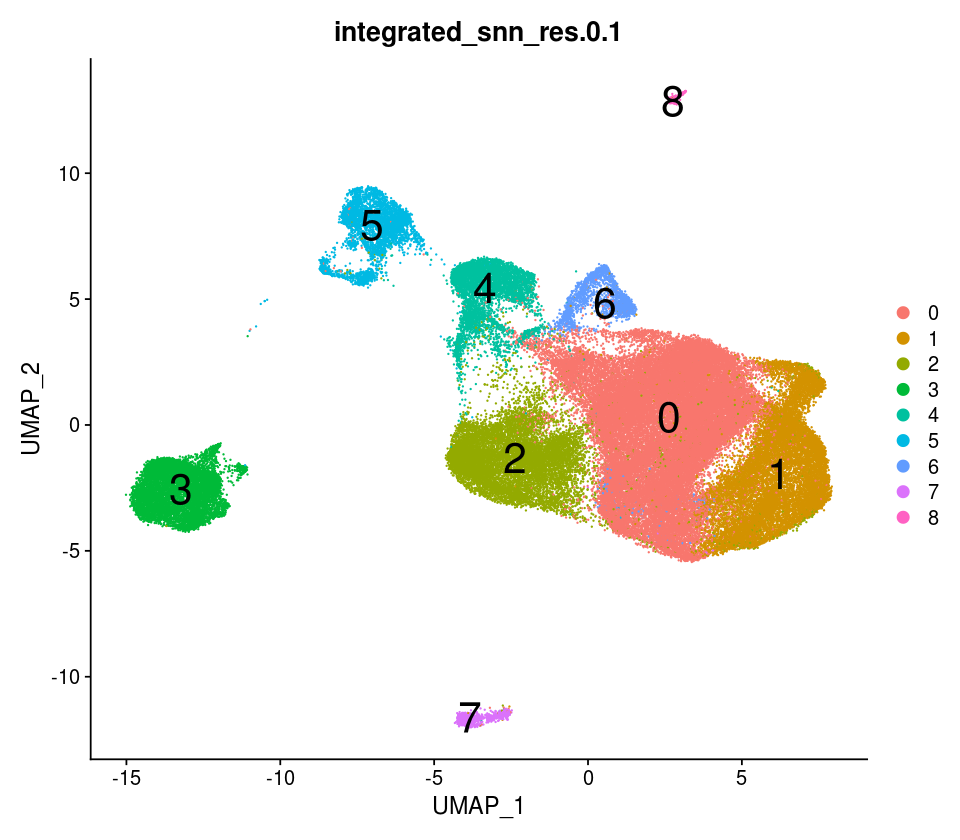

In [4]:
options(repr.plot.height = 7, repr.plot.width = 8)
p1 = DimPlot(nobj, group.by = "integrated_snn_res.0.1", label = T, label.size = 9)
p1

In [5]:
table(nobj@meta.data$integrated_snn_res.0.1)


    0     1     2     3     4     5     6     7     8 
37528 14413 11147  8065  5240  4143  2094   950   391 

In [6]:
cell2col = fread(paste("1.Metadata", "cell2col.txt", sep = "/"), data.table = F)
# cell2col$rna.short = c("NKX6-1+", "Rep.\nNKX6-1+", "iPSC", "PDX1+", "Mes.", "E.DE", "Endo.", "E.Ductal", rep(NA, nrow(cell2col)-8))
head(cell2col)

,col,rna.cluster,rna.celltype,atac.cluster,atac.celltype,rna.short,rna.cell,atac.cell,atac.tmp
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,#1B9E77,Cluster 0,NKX-1+ Progenitors Cluster 0,0,NKX6-1+ Progenitors Cluster 0,NKX6-1+,NKX6-1+ Progenitors,NKX6-1+ Progenitors,NKX6-1+
2,#D95F02,Cluster 1,Replicating NKX6-1+ Progenitors Cluster 1,NA,,Rep. NKX6-1+,Rep. NKX6-1+ Progenitors,,
3,#7570B3,Cluster 2,iPSC Cluster 2,NA,,iPSC,iPSC,,
4,#E7298A,Cluster 3,PDX1+ Progenitors Cluster 3,NA,,PDX1+,PDX1+ Progenitors,,
5,#66A61E,Cluster 4,Mesendoderm Cluster 4,1,Mesendoderm Cluster 1,Mes.,Mesendoderm,Mesendoderm,Mes.
6,#E6AB02,Cluster 5,Early Definitive Endoderm Cluster 5,NA,,E.Def.Endo.,Early Definitive Endoderm,,


In [7]:
cell_order = c("iPSC", "Mes.", "E.Def.Endo.", "PDX1+", "NKX6-1+", "Rep.\nNKX6-1+", "Endo.", "E.Ductal")
    col_order  = suppressMessages(mapvalues(cell_order, from = cell2col$rna.short, to = cell2col$col))
col_order

[1] "#7570B3" "#66A61E" "#E6AB02" "#E7298A" "#1B9E77" "#D95F02" "#A6761D"
[8] "#666666"

In [8]:
data_summary <- function(x) {
   m <- mean(x)
   ymin <- m-sd(x)
   ymax <- m+sd(x)
   return(c(y=m,ymin=ymin,ymax=ymax))
}

In [10]:
data = GetAssayData(nobj, "data")
meta = nobj@meta.data
genes = c("POU5F1", "COL1A1", "COL1A2", "AFP",  "APOA2", "GATA4", "GATA6", "PDX1", "NKX6-1", "PAX6", "CHGA", "INS", "GCG", "SST", "FLT1", "TOP2A", "CENPF", "AURKB")

plotlist=  list()

for (gene in genes){
   toplot = data.frame(exp = data[gene,], cells = colnames(data))
    toplot$cluster = as.numeric(suppressMessages(mapvalues(toplot$cells, from = rownames(meta), to = meta$integrated_snn_res.0.1)))
    toplot$cluster = toplot$cluster - 1
    toplot$cluster = factor(toplot$cluster, levels = c(0:7))

    from = c(0:7)
    to = c("NKX6-1+", "Rep.\nNKX6-1+", "iPSC", "PDX1+", "Mes.", "E.Def.Endo.", "Endo.", "E.Ductal")

    toplot$cell = suppressMessages(mapvalues(toplot$cluster, from = from, to = to))

    cell_order = c("iPSC", "Mes.", "E.Def.Endo.", "PDX1+", "NKX6-1+", "Rep.\nNKX6-1+", "Endo.", "E.Ductal")
    col_order  = suppressMessages(mapvalues(cell_order, from = cell2col$rna.short, to = cell2col$col))
    toplot$cell = factor(toplot$cell, levels = cell_order)

    options(repr.plot.height= 8 , repr.plot.width = 15)
    p = ggplot(toplot, aes(x = cell, y = exp, fill = cell)) + geom_violin(scale = "width") + jn_theme + 
         ylab("Normalized Expression") + xlab("") + scale_fill_manual(values = col_order) + 
        theme(legend.position = "none", axis.text.x = element_text(colour = col_order), 
              panel.border = element_blank(), axis.line.y = element_line(color = "black"),
              axis.ticks.x = element_blank(), plot.title = element_text(hjust = 0.5, size = 30),
              axis.text = element_text(size = 25), axis.title = element_text(size = 25)) + ggtitle(gene) +
        stat_summary(fun.data=data_summary)
    plotlist[[gene]] = p
}



png 
  2

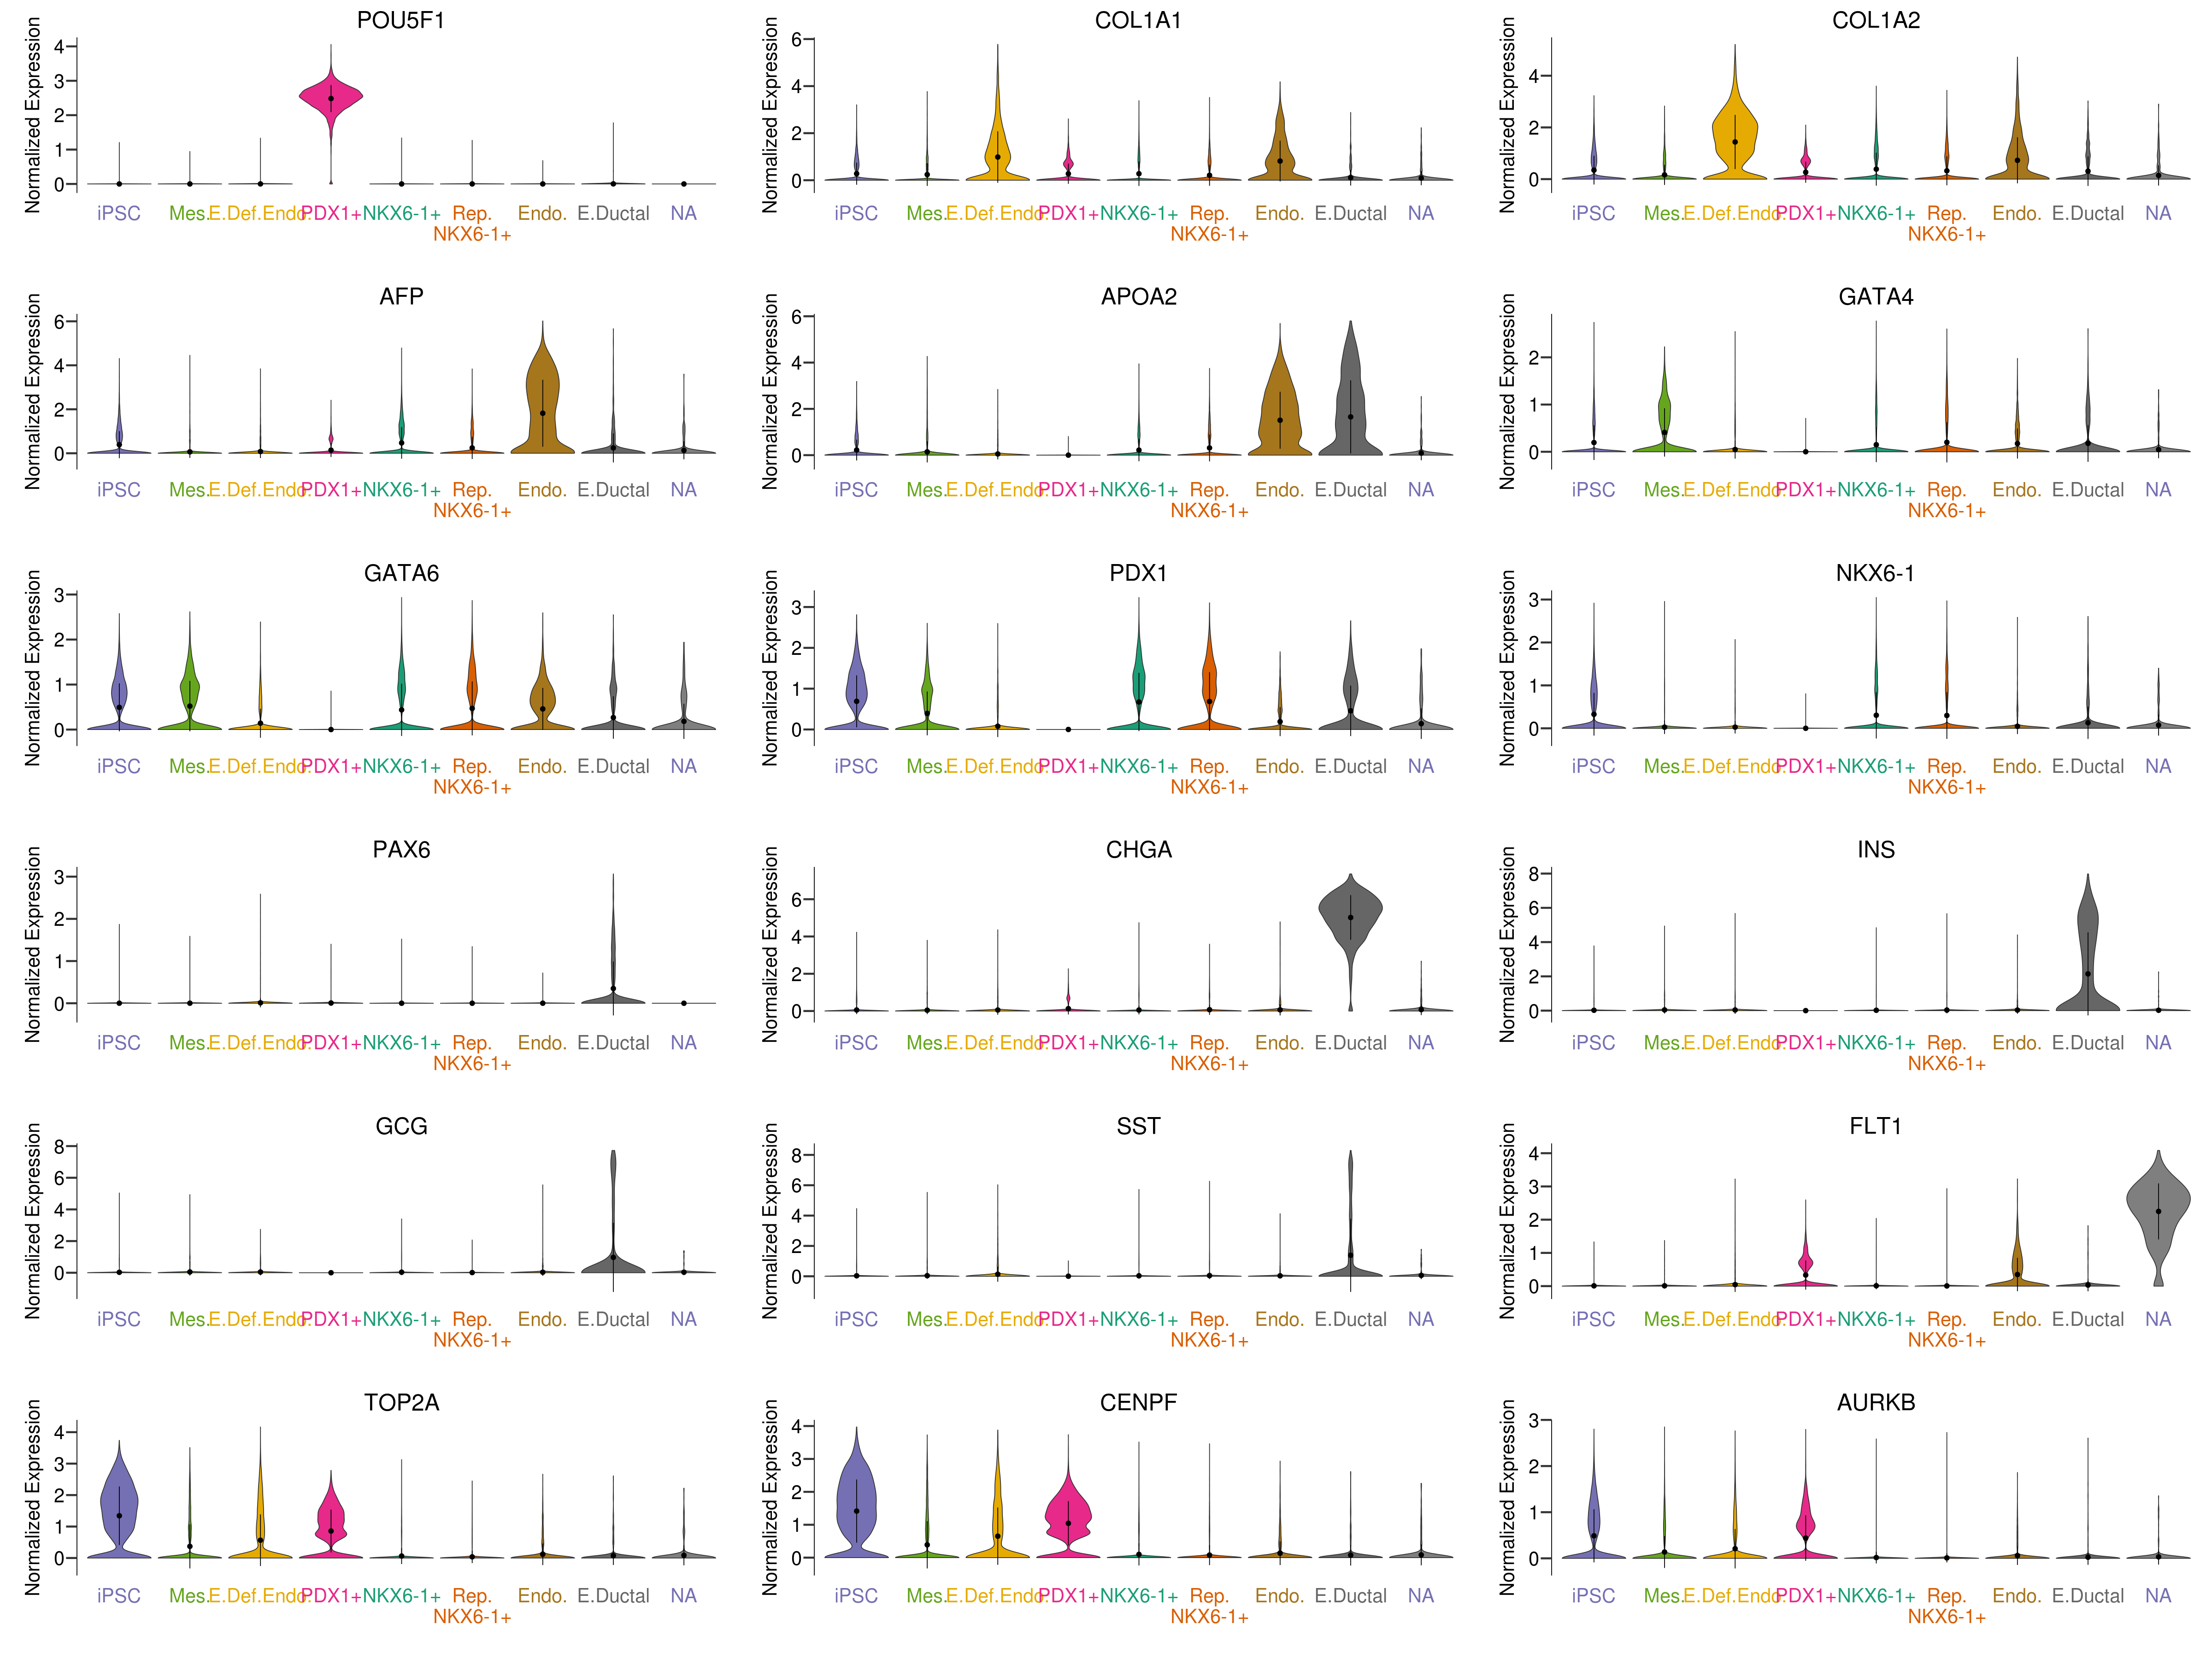

In [11]:
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 30)
png(paste("../figures/png/violin_plots.png"), width = 3200, height = 2500)
plot_grid(plotlist = plotlist, ncol = 3)
dev.off()

plot_grid(plotlist = plotlist, ncol = 3)